In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip3 install tensorflow

# we can use sageMaker from AWS or googlecolab to do the exercises

# this week we will do a classifier of images. We will deploy a service and the user will upload images to a website that then will be fed to the service and it will upload what type of clothe it is from 10 different.

# 8.1:

#   more info in: https://cs231n.github.io

# first clone the dataset : git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

print ("\n8.2: TensorFlow and Keras\n")

# Tensorflow is a framework for doing/training deep learning models
# pip3 install tensorflow
# Keras is a higher level abstraction on top of TensorFlow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img

from google.colab import drive
drive.mount('/content/gdrive')

#from tensorflow.keras.preprocessing.image import load_img
# for earlier versions is from keras.preprocessing.image import load_img
#path = './clothing-dataset-small/train/t-shirt'
path = './gdrive/MyDrive/clothing-dataset-small/train/t-shirt'

name = 'ffb8b476-17bc-4f7f-8f37-4ae8e6007128.jpg' #this image is in my comp: /home/ibai/work/MLzoomcamp/08-deep-learning/clothing-dataset-small/train/t-shirt/
#I copied the file to /content

fullname = f'{path}/{name}'
img = load_img(fullname, target_size = (299,299))
#print (img)

#each pixel is a cobination of red green and blue in each image, in a matrix of 150x150
x =  np.array(img)
#print (x)
#print (x.shape())





8.2: TensorFlow and Keras

Mounted at /content/gdrive


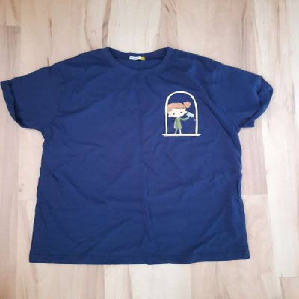

In [2]:
img

In [3]:
print ("\n8.3: Pre-trained convolutional neural networks\n")
# imagenet dataset: https://www.image-net.org/
# pre-trained models: https://keras.io/api/applications/


8.3: Pre-trained convolutional neural networks



In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [5]:
model = Xception(weights='imagenet', input_shape=(299,299,3)) # this will download the Exception model from internet and will use the imagenet database

91884032/91884032 [==============================] - 1s 0us/step


In [6]:
X = np.array([x]) #X can be 1 image or many. to feed to the model

In [7]:
X.shape

(1, 299, 299, 3)

In [8]:
X = preprocess_input(X)

In [9]:
pred = model.predict(X) #we get almost only zeros. we need to preprocess X so it can predict properly. for that We can use preprocess_input
# after preprocessing, we get different numbers

1/1 [==============================] - 12s 12s/step


In [10]:
pred.shape #we get 1000 classes. each of the numbers in "pred" represents the likelyhood of the image to belong to a class

(1, 1000)

In [11]:
decode_predictions(pred) # to know which class belong the most probable

35363/35363 [==============================] - 0s 0us/step


[[('n03595614', 'jersey', 0.6363583),
  ('n04370456', 'sweatshirt', 0.04750097),
  ('n03710637', 'maillot', 0.013579542),
  ('n03877472', 'pajama', 0.0064726495),
  ('n04599235', 'wool', 0.0028374135)]]

In [12]:
# apparently this model is not so good because we gave a tshirt and says jersey. So we will train our model

In [13]:
print ("\n8.4: convolutional neural networks\n")

# converts an image into vector representation, then we have dense vectors and those are taking to do the prediction

# we can use these models and create binary classification predictors or no binary also.


8.4: convolutional neural networks



In [14]:
print ("\n8.5 Transfer Learning\n")

# Normally, the learning into vector representation of many models is very generic. But the dense layers afterwars are specific to the dataset.
# SO we want to keep the convolutional layers (the first ones) and train the dense layers.
# So we reuse the learning knowledge and that is transfer learning

from tensorflow.keras.preprocessing.image import ImageDataGenerator



8.5 Transfer Learning



In [16]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './gdrive/MyDrive/clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
    )

Found 3068 images belonging to 10 classes.


In [17]:
train_ds.class_indices  #it puts as key the name of the folder

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [18]:
X, y = next(train_ds) # to get next batch

In [19]:
X.shape

(32, 150, 150, 3)

In [20]:
y[:5] #each column is each key in class_indices. This is Multiclass Classification with one hot encoding. it is 1 if it is of that type and 0 if it is not

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [21]:
# lets do in the validation dataset
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './gdrive/MyDrive/clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32, #for validation we do not need to shuffle
    shuffle=False
    )

Found 341 images belonging to 10 classes.


In [ ]:

base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
    # bsae model will be the convolutional mode. And later we will create our custom model. Base model will be Xception. We will use Xception to extract the vectore repsentation
    # incluse top false means not including the dense layers, beucase models in keras are going from bottom to top

base_model.trainable = False # do not change convolutional layers. DO not train it.


inputs = keras.Input(shape=(150, 150, 3)) # the input is matrixes of 3 values, 150x by 150 and then a depth of 32 (batch)
base = base_model(inputs, training=False)

# We want to turn this into vector representation.
# For that we can slice the 4D data do average of each slice and convert into a 3D
vectors = keras.layers.GlobalAveragePooling2D()(base)

# now we want to turn the predictions into 32x10 which are the number of classes
# so we create a dense layer.
outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)


83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
preds = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [ ]:
preds.shape # 4Dimensions, 32 is the batch size, so 32x[5x5x2048].
#We want to turn this into vector representation.
# For that we can slice the 4D data do average of each slice and convert into a 3D
# this is called 2D average POOLING. We do that with pooling = keras.layers.GlobalAveragePooling2D()
# now we got 32x2048
# and later, after creating the dense layer, we get 32x10


(32, 10)

In [ ]:
preds[0] # this is a bunch of numbers that do not make sense, just initialized. Because we did not train the dense layer yet.

array([ 1.1355547 , -1.3622494 , -0.59437704,  0.55614364, -0.47551104,
        1.4109133 ,  0.28451195,  1.7238503 , -0.19150375,  2.6904354 ],
      dtype=float32)

In [ ]:
learning_rate = 0.01 # similar to eta in xgboost
optimizer = keras.optimizers.Adam(learning_rate=learning_rate) # this changes the weights. There are many types of optimizers. Check also in cs231
# optimizers use gradient descend

#optimizers needs a way to know if it learns anything or not.
loss = keras.losses.CategoricalCrossentropy(from_logits=True) # Logitst is the layer before the SoftMax(The activation layer)
# a way of evaluating multiclass classification models. The lower the number the better
#for binary is BinaryCrossentrou
#for regression we use meansquared error

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds,workers=2560) #dataset is composed of batches of 32, for example. Each iteration over all the batches is an epoch

Epoch 1/10
96/96 [==============================] - 20s 195ms/step - loss: 0.5785 - accuracy: 0.8259 - val_loss: 0.9080 - val_accuracy: 0.7771
Epoch 2/10
96/96 [==============================] - 19s 180ms/step - loss: 0.3418 - accuracy: 0.8833 - val_loss: 0.8586 - val_accuracy: 0.7830
Epoch 3/10
96/96 [==============================] - 20s 185ms/step - loss: 0.2016 - accuracy: 0.9329 - val_loss: 1.1258 - val_accuracy: 0.7537
Epoch 4/10
96/96 [==============================] - 16s 148ms/step - loss: 0.1867 - accuracy: 0.9342 - val_loss: 0.8590 - val_accuracy: 0.8123
Epoch 5/10
96/96 [==============================] - 18s 164ms/step - loss: 0.0914 - accuracy: 0.9729 - val_loss: 0.8380 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 22s 185ms/step - loss: 0.0649 - accuracy: 0.9769 - val_loss: 0.9054 - val_accuracy: 0.7918
Epoch 7/10
96/96 [==============================] - 16s 155ms/step - loss: 0.0445 - accuracy: 0.9892 - val_loss: 0.8491 - val_accuracy: 0.8123

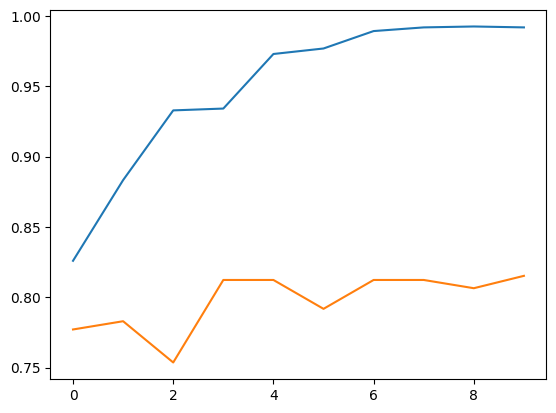

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='train')

In [ ]:
# we can see that it is very close to 1 the training, while for validation not more than 80, which is overfitting.

# we will do some tunning now

print ("\n8.6: Adjusting the learning rate\n")
# the learning rate (eta) is the most important value to adjust.
# learning rate is like how fast we can read books. reading 1 book only a year is slow but we learn all the book,
# while if we read 1 every day maybe we do not get all the concepts, maybe we just check images and so. SO we
# need a medium speed


8.6: Adjusting the learning rate



In [ ]:
def make_model (learning_rate=0.01):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150,150,3)
    )
    base_model.trainable = False

    ##############################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)

    ##############################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'])
    return model

In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print (lr)
    model = make_model(lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds,workers=2560)
    scores[lr] = history.history
    print ()
    print ()


0.0001
Epoch 1/10
96/96 [==============================] - 25s 219ms/step - loss: 1.9609 - accuracy: 0.3334 - val_loss: 1.6026 - val_accuracy: 0.5103
Epoch 2/10
96/96 [==============================] - 20s 186ms/step - loss: 1.4059 - accuracy: 0.5574 - val_loss: 1.2493 - val_accuracy: 0.6012
Epoch 3/10
96/96 [==============================] - 27s 254ms/step - loss: 1.1553 - accuracy: 0.6366 - val_loss: 1.0702 - val_accuracy: 0.6598
Epoch 4/10
96/96 [==============================] - 22s 210ms/step - loss: 1.0127 - accuracy: 0.6793 - val_loss: 0.9556 - val_accuracy: 0.6921
Epoch 5/10
96/96 [==============================] - 20s 190ms/step - loss: 0.9177 - accuracy: 0.7066 - val_loss: 0.8817 - val_accuracy: 0.7214
Epoch 6/10
96/96 [==============================] - 22s 209ms/step - loss: 0.8498 - accuracy: 0.7295 - val_loss: 0.8275 - val_accuracy: 0.7361
Epoch 7/10
96/96 [==============================] - 21s 208ms/step - loss: 0.7945 - accuracy: 0.7445 - val_loss: 0.7866 - val_accuracy:

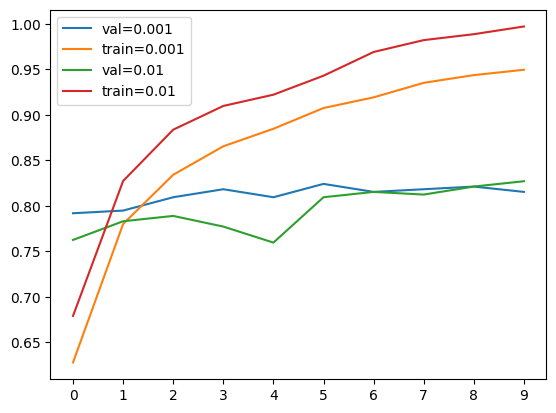

In [ ]:
#del scores[0.1]
#del scores[0.0001] # these are the worst

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.xticks(np.arange(10))
    plt.legend()


In [ ]:


learning_rate = 0.001 # we select this because comparing 0.001 and 0.01, 0.01 has lower validation and also higher training, which has overfitting.
 # (at least that was in Alexeis example)

In [ ]:
print ("\n8.7: Checkpointing\n") # checpointing means saving the model in the iterations with highest scores, like the peaks in the plots when training.



8.7: Checkpointing



In [ ]:
model.save_weights('model_v1.h5', save_format=('h5'))

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True, #this is a variable that saves when it is the best compared to the past models
    monitor='val_accuracy',
    mode='max'
)

In [ ]:
learning_rate = 0.001
model = make_model(learning_rate=learning_rate)
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint],
    workers=2560)


Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.1255 - accuracy: 0.6281

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 26s 214ms/step - loss: 1.1255 - accuracy: 0.6281 - val_loss: 0.7412 - val_accuracy: 0.7801
Epoch 2/10
96/96 [==============================] - 24s 232ms/step - loss: 0.6298 - accuracy: 0.7872 - val_loss: 0.6462 - val_accuracy: 0.7918
Epoch 3/10
96/96 [==============================] - 27s 239ms/step - loss: 0.5068 - accuracy: 0.8338 - val_loss: 0.5987 - val_accuracy: 0.8006
Epoch 4/10
96/96 [==============================] - 22s 215ms/step - loss: 0.4369 - accuracy: 0.8563 - val_loss: 0.5744 - val_accuracy: 0.8182
Epoch 5/10
96/96 [==============================] - 23s 223ms/step - loss: 0.3736 - accuracy: 0.8866 - val_loss: 0.5627 - val_accuracy: 0.8006
Epoch 6/10
96/96 [==============================] - 36s 358ms/step - loss: 0.3330 - accuracy: 0.9081 - val_loss: 0.5737 - val_accuracy: 0.8182
Epoch 7/10
96/96 [==============================] - 24s 222ms/step - loss: 0.2972 - accuracy: 0.9140 - val_loss: 0.5456 - val_accuracy: 0.8299
Epoch 8/10

In [ ]:
print ("\n8.8: Adding More layers\n")

In [ ]:
def make_model (learning_rate=0.01,size_inner=100):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150,150,3)
    )
    base_model.trainable = False

    ##############################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)

    ##############################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)   # if this was false, we would add in the layer above: , activation='softmax'
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'])
    return model

# each dense layer needs an activation to perform well. Previously we had only 1 layer and logits = True, what means that we take directly the raw values.
# we can add to the last layer softmax or sigmoid, which are activations to put in the output
# now we are adding another dense layer in the middle. We will add a relu activation to it . There are many,m but if not sure, add Relu

In [ ]:
learning_rate = 0.001
scores = {}
for size in [10, 100, 1000]:
    print (size)
    model = make_model(learning_rate = learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds,workers=2560)
    scores[size] = history.history
    print ()
    print ()


10
Epoch 1/10
96/96 [==============================] - 27s 228ms/step - loss: 1.3748 - accuracy: 0.5505 - val_loss: 0.8770 - val_accuracy: 0.7361
Epoch 2/10
96/96 [==============================] - 23s 215ms/step - loss: 0.7763 - accuracy: 0.7379 - val_loss: 0.6905 - val_accuracy: 0.7801
Epoch 3/10
96/96 [==============================] - 22s 207ms/step - loss: 0.5927 - accuracy: 0.8061 - val_loss: 0.6462 - val_accuracy: 0.7947
Epoch 4/10
96/96 [==============================] - 24s 218ms/step - loss: 0.4821 - accuracy: 0.8465 - val_loss: 0.5948 - val_accuracy: 0.8094
Epoch 5/10
96/96 [==============================] - 23s 215ms/step - loss: 0.4147 - accuracy: 0.8621 - val_loss: 0.5910 - val_accuracy: 0.8152
Epoch 6/10
96/96 [==============================] - 22s 213ms/step - loss: 0.3528 - accuracy: 0.8921 - val_loss: 0.5612 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 28s 258ms/step - loss: 0.3004 - accuracy: 0.9130 - val_loss: 0.5549 - val_accuracy: 0.8

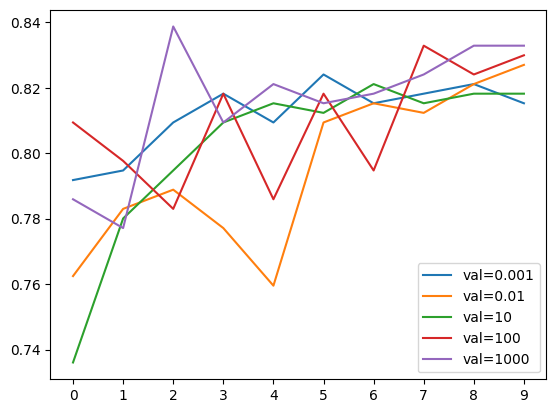

In [ ]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.xticks(np.arange(10))
    plt.legend()

In [23]:
print ("\n8.9: Regularization and dropout\n")
# Dropuout is a way of regularizing. It is a way of preventing overfitting
# imagine that we have a tshirt with a logo. If we do many epochs, like 10, the model learns 10 times the same, and it can associate for example the logo with a tshirt. And if we see the logo
# in a trouser, it could call it a tshirt.
# to fight this, we hide with a part of the image, for example, with a patch, so everytime it sees the image in each epoch, it will be slighly different.
# to do this, we can freeze different part of the network, like a neuron in the inner layer.


8.9: Regularization and dropout



In [25]:
def make_model (learning_rate=0.01,size_inner=100, droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150,150,3)
    )
    base_model.trainable = False

    ##############################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner) # droprate is the percentage of the inner layer that gets frozen

    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)

    ##############################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)   # if this was false, we would add in the layer above: , activation='softmax'
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'])
    return model

# each dense layer needs an activation to perform well. Previously we had only 1 layer and logits = True, what means that we take directly the raw values.
# we can add to the last layer softmax or sigmoid, which are activations to put in the output
# now we are adding another dense layer in the middle. We will add a relu activation to it . There are many,m but if not sure, add Relu

In [26]:
learning_rate = 0.001
size = 100
scores = {}
for droprate in [0, 0.2,0.5,0.8]:
    print (droprate)
    model = make_model(
        learning_rate = learning_rate,
        size_inner=size,
        droprate=droprate
      )
    history = model.fit(train_ds, epochs=30, validation_data=val_ds,workers=2560) # because of the droprate, we need more epochs
    scores[droprate] = history.history
    print ()
    print ()

0
83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/30
96/96 [==============================] - 117s 1s/step - loss: 0.9844 - accuracy: 0.6653 - val_loss: 0.6551 - val_accuracy: 0.7918
Epoch 2/30
96/96 [==============================] - 22s 214ms/step - loss: 0.5234 - accuracy: 0.8149 - val_loss: 0.5712 - val_accuracy: 0.8094
Epoch 3/30
96/96 [==============================] - 22s 202ms/step - loss: 0.3562 - accuracy: 0.8843 - val_loss: 0.5277 - val_accuracy: 0.8358
Epoch 4/30
96/96 [==============================] - 23s 224ms/step - loss: 0.2496 - accuracy: 0.9211 - val_loss: 0.5721 - val_accuracy: 0.8035
Epoch 5/30
96/96 [==============================] - 22s 204ms/step - loss: 0.1830 - accuracy: 0.9534 - val_loss: 0.5135 - val_accuracy: 0.8358
Epoch 6/30
96/96 [==============================] - 24s 232ms/step - loss: 0.1244 - accuracy: 0.9703 - val_loss: 0.5588 - val_accuracy: 0.8152
Epoch 7/30
96/96 [==============================] - 24s 215ms/step - loss: 0.

NameError: ignored

In [ ]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
    plt.xticks(np.arange(30))
    plt.legend()

In [ ]:
hist = scores[0.5]
plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.plot(hist['accuracy'], label=('val=%s' % droprate))
# this one at 0.5 has a high score but it looks pure luck

In [ ]:
hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.plot(hist['accuracy'], label=('val=%s' % droprate))
# 0.2 looks better, many times reaches around 0.84 accuracy. It is also better than the models with no dropout

In [ ]:
print ("\n8.10: Data augmentation\n")

# this is another way for regularization. We generate more data from existing data. This also prevents from seeing the same image over and over again.
# Data augmentation is another way of achieving the same as droput

# We want to generate more images.
# we can take an image and flip it. Horizontally and vertically.
# we can also rotate different degrees
# also shiftting the image a little bit, left right up and down. So the height and the width also
# shear also, which is different to roration
# zooming the X, and/or the Y
# and many more

#all can be combined



In [27]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rotation_range=30,
    #width_shift_range=10.0,
    #height_shift_range=10.0,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True,
  )
# which augmentations should I choose? Use my own judgement
# we can also tune as a hyperparameter

# we do not apply augmentation to the validation ebcause we want to compare with something consistent always

train_ds = train_gen.flow_from_directory(
    './gdrive/MyDrive/clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
    )

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './gdrive/MyDrive/clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32, #for validation we do not need to shuffle
    shuffle=False
    )


Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [28]:
learning_rate = 0.001
size = 100
droprate = 0.2


model = make_model(
    learning_rate = learning_rate,
    size_inner=size,
    droprate=droprate
  )
history = model.fit(train_ds, epochs=50, validation_data=val_ds,workers=2560) # because of the droprate and augmentation, we need more epochs


Epoch 1/50
96/96 [==============================] - 48s 395ms/step - loss: 1.2877 - accuracy: 0.5658 - val_loss: 0.7598 - val_accuracy: 0.7419
Epoch 2/50
96/96 [==============================] - 51s 488ms/step - loss: 0.9238 - accuracy: 0.6848 - val_loss: 0.7526 - val_accuracy: 0.7449
Epoch 3/50
96/96 [==============================] - 54s 499ms/step - loss: 0.7978 - accuracy: 0.7233 - val_loss: 0.6537 - val_accuracy: 0.7918
Epoch 4/50
96/96 [==============================] - 40s 392ms/step - loss: 0.7193 - accuracy: 0.7484 - val_loss: 0.6718 - val_accuracy: 0.7801
Epoch 5/50
96/96 [==============================] - 39s 362ms/step - loss: 0.6295 - accuracy: 0.7806 - val_loss: 0.6172 - val_accuracy: 0.7889
Epoch 6/50
96/96 [==============================] - 49s 465ms/step - loss: 0.6027 - accuracy: 0.8012 - val_loss: 0.6877 - val_accuracy: 0.7713
Epoch 7/50
96/96 [==============================] - 44s 419ms/step - loss: 0.5690 - accuracy: 0.7976 - val_loss: 0.6763 - val_accuracy: 0.7889

KeyboardInterrupt: ignored

In [ ]:
# the training takes more because the augmentation is in the CPU and the training on GPU.
# We can also parallelize both CPU and GPU, like, occupy the CPU with batch2 while training of batch1 is taking place on the GPU

# values are worse now. Alexei says that sometimes augmentation maybe does not really help, or it is other types of augmentation
# the best would be to take the old model without and train now in more images.

hist = history.history
plt.plot(hist['val_accuracy'], label="val")
plt.plot(hist['accuracy'], label="train")

In [31]:
print ("\n8.14: Train a larger model\n")



8.14: Train a larger model



In [37]:
def make_model (input_size = 150, learning_rate=0.01,size_inner=100, droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size,input_size,3)
    )
    base_model.trainable = False

    ##############################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner) # droprate is the percentage of the inner layer that gets frozen

    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)

    ##############################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)   # if this was false, we would add in the layer above: , activation='softmax'
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'])
    return model

# each dense layer needs an activation to perform well. Previously we had only 1 layer and logits = True, what means that we take directly the raw values.
# we can add to the last layer softmax or sigmoid, which are activations to put in the output
# now we are adding another dense layer in the middle. We will add a relu activation to it . There are many,m but if not sure, add Relu

In [38]:
input_size = 299


In [39]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rotation_range=30,
    #width_shift_range=10.0,
    #height_shift_range=10.0,
    #shear_range=10,
    #zoom_range=0.1,
    #horizontal_flip=True,
    #vertical_flip=True,
  )
# which augmentations should I choose? Use my own judgement
# we can also tune as a hyperparameter

# we do not apply augmentation to the validation ebcause we want to compare with something consistent always

train_ds = train_gen.flow_from_directory(
    './gdrive/MyDrive/clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
    )

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './gdrive/MyDrive/clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32, #for validation we do not need to shuffle
    shuffle=False
    )


Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [40]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True, #this is a variable that saves when it is the best compared to the past models
    monitor='val_accuracy',
    mode='max'
)

In [41]:
learning_rate = 0.0005
size = 100
droprate = 0.2


model = make_model(
    input_size = input_size,
    learning_rate = learning_rate,
    size_inner=size,
    droprate=droprate
  )
history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                    workers=2560,
                    callbacks=[checkpoint]) # because of the droprate and augmentation, we need more epochs


Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.9897 - accuracy: 0.6861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 55s 450ms/step - loss: 0.9897 - accuracy: 0.6861 - val_loss: 0.5279 - val_accuracy: 0.8446
Epoch 2/50
96/96 [==============================] - 42s 416ms/step - loss: 0.4896 - accuracy: 0.8409 - val_loss: 0.4302 - val_accuracy: 0.8446
Epoch 3/50
96/96 [==============================] - 47s 458ms/step - loss: 0.3922 - accuracy: 0.8699 - val_loss: 0.3926 - val_accuracy: 0.8622
Epoch 4/50
96/96 [==============================] - 42s 416ms/step - loss: 0.3308 - accuracy: 0.8885 - val_loss: 0.3736 - val_accuracy: 0.8739
Epoch 5/50
96/96 [==============================] - 54s 516ms/step - loss: 0.2945 - accuracy: 0.9003 - val_loss: 0.3722 - val_accuracy: 0.8680
Epoch 6/50
96/96 [==============================] - 52s 495ms/step - loss: 0.2650 - accuracy: 0.9120 - val_loss: 0.3477 - val_accuracy: 0.8739
Epoch 7/50


KeyboardInterrupt: ignored

In [43]:
print ("\n8.12: Using the model\n")

# lets do as if everything is new

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


keras.models.load_model("/content/xception_v4_04_0.874.h5")

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './gdrive/MyDrive/clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
    )



8.12: Using the model

Found 372 images belonging to 10 classes.


In [44]:
# Lets evaluate our model in the test dataset
model.evaluate(test_ds) # first number is categorical crossentropy, the second is the accuracy.

12/12 [==============================] - 108s 10s/step - loss: 0.2973 - accuracy: 0.8898


[0.2972680330276489, 0.8897849321365356]

In [45]:
# now lets predict one image
path = '/content/gdrive/MyDrive/clothing-dataset-small/test/hat/2a12baab-f020-42e3-8e6b-5d82e3ed0b55.jpg'
img = load_img(path,target_size=(299,299))


In [46]:
import numpy as np

In [47]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [49]:
X = preprocess_input(X)

In [50]:
pred = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [52]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [53]:
dict(zip(classes,pred[0])) # Hat is the biggest number, so it has higher probability.

{'dress': -0.2930585,
 'hat': 2.9631488,
 'longsleeve': -1.2809428,
 'outwear': 0.91038704,
 'pants': -0.6245805,
 'shirt': -0.65404457,
 'shoes': 1.0580088,
 'shorts': -1.9643601,
 'skirt': 0.3087918,
 't-shirt': -2.9875493}